Audio Classifier
=========================

## Important information

* Choose a group name/number and rename the file with it.
* Be sure to enter the names of every member in the group in the cell below.
* Use the power of number and work together as a team.
* You can employ the use of the HPC (high perfomance computer) provided your server account has been established.
* The tutor is always available to give more explanation and assistance whenever/wherever required, but make sure you have made effort yourself.
* Please remove all test codes.
* The solutions to the tasks should be turn in on Friday 13th Dec, end of the day (12am). 
* A notebook submission is required per group, no multiple submissions from same group. Submit by attaching only the .ipynb file please, not zip and I don't need other files (e.g the data) I already have them.

Group ......

    Member 1
    Member 2
    Member 3
    Member 4

This task is inspired by the Audio Classifier Tutorial (found [here](https://pytorch.org/tutorials/beginner/audio_classifier_tutorial.html?highlight=audio))
**Author**: `Winston Herring <https://github.com/winston6>`_

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset. First, let’s
import the common torch packages as well as ``torch``, ``torchaudio``, ``pandas``,
and ``numpy``. ``torchaudio`` is available `here <https://github.com/pytorch/audio>`_
and can be installed by following the
instructions on the website but I encountered a lot of trouble installing it, this ` conda install -c pytorch torchaudio-cpu ` rather worked for me.

If you have a CUDA GPU use that. Running
the network on a GPU will greatly decrease the training/testing runtime.




1: Importing the Dataset
---------------------

We will use the UrbanSound8K dataset to train our network. It is
available for free `here <https://urbansounddataset.weebly.com/>`_ and contains
10 audio classes with over 8000 audio samples! Once you have downloaded
the compressed dataset, extract it to your current working directory.
First, we will look at the csv file that provides information about the
individual sound files. ``pandas`` allows us to open the csv file and
use ``.iloc()`` to access the data within it.




The 10 audio classes in the UrbanSound8K dataset are air_conditioner,
car_horn, children_playing, dog_bark, drilling, enginge_idling,
gun_shot, jackhammer, siren, and street_music. Let’s play a couple files
and see what they sound like. The first file is street music and the
second is an air conditioner.




2: Formatting the Data
-------------------

Now that we know the format of the csv file entries, we can construct
our dataset. We will create a rapper class for our dataset using
``torch.utils.data.Dataset`` that will handle loading the files and
performing some formatting steps. The UrbanSound8K dataset is separated
into 10 folders. We will use the data from 9 of these folders to train
our network and then use the 10th folder to test the network. The rapper
class will store the file names, labels, and folder numbers of the audio
files in the inputted folder list when initialized. The actual loading
and formatting steps will happen in the access function ``__getitem__``.

In ``__getitem__``, we use ``torchaudio.load()`` to convert the wav
files to tensors. ``torchaudio.load()`` returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(44.1kHz for UrbanSound8K). The dataset uses two channels for audio so
we will use ``torchaudio.transforms.DownmixMono()`` (not available in the latest version of `torchaudio`) to convert the audio
data to one channel. Next, we need to format the audio data. The network
we will make takes an input size of 32,000, while most of the audio
files have well over 100,000 samples. The UrbanSound8K audio is sampled
at 44.1kHz, so 32,000 samples only covers around 700 milliseconds. By
downsampling the audio to aproximately 8kHz, we can represent 4 seconds
with the 32,000 samples. This downsampling is achieved by taking every
fifth sample of the original audio tensor. Not every audio tensor is
long enough to handle the downsampling so these tensors will need to be
padded with zeros. The minimum length that won’t require padding is
160,000 samples.




3: Define the Network
------------------

For this task we want to closely reproduce the achitectures described in https://arxiv.org/pdf/1610.00087.pdf. You task is to read extensively the paper and reproduce the achitectures <font color='green'> M3, M5, M11 and M18. The M34-res is a bonus.</font>
While attempting to reproduce the architectures endeavour to read through the common [pitfalls](https://urbansounddataset.weebly.com/urbansound8k.html#10foldCV) to get it right.

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training.




4: Training and Testing the Network
--------------------------------

You can define a training function that will feed our training data into the model and perform the backward pass and optimization steps. You can also make one for testing the networks accuracy and set the model to ``eval()`` mode and then run inference on the test dataset. Calling ``eval()`` sets the training variable in all modules in the network to false. Certain layers like batch normalization and dropout layers behave differently during training so this step is crucial for getting correct results.




Finally, we can train and test the network. Train the network for as many epochs as time allows you. The network will be tested after each epoch to see how the accuracy varies during the training.

Conclusion
----------

If trained on 9 folders, the network should be about 40% accurate by the end of the training process for the least possible epochs. Training on less folders will result in a lower overall accuracy. Greater accuracies can be achieved using deeper CNNs at the expense of a larger memory footprint.

For more advanced audio applications, such as speech recognition,
recurrent neural networks (RNNs) are commonly used. There are also other
data preprocessing methods, such as finding the mel frequency cepstral
coefficients (MFCC), that can reduce the size of the dataset.




<font color='red'>GOOD NEWS</font> : Solutions to the first two section have been given to you freely. <font color='blue'>You are welcome</font>. 

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchaudio
from torch.optim.lr_scheduler import StepLR
import datetime

In [2]:
#rapper for the UrbanSound8K dataset
#!pip3 install torchaudio

In [15]:
class AudioDataset(Dataset):
    """
    A rapper class for the UrbanSound8K dataset.
    """

    def __init__(self, file_path, audio_paths, folds):
        """
        Args:
            file_path(string): path to the audio csv file
            root_dir(string): directory with all the audio folds
            folds: integer corresponding to audio fold number or list of fold number if more than one fold is needed
        """
        self.audio_file = pd.read_csv(file_path)
        self.folds = folds
        self.audio_paths = glob.glob(audio_paths + '/*' + str(self.folds) + '/*')
    
    

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        
        audio_path = self.audio_paths[idx]
        audio, rate = torchaudio.load(audio_path, normalization=True)
        audio = audio.mean(0, keepdim=True)
        c, n = audio.shape
        zero_need = 160000 - n
        audio_new = F.pad(audio, (zero_need //2, zero_need //2), 'constant', 0)
        audio_new = audio_new[:,::5]
        
        #Getting the corresponding label
        audio_name = audio_path.split(sep='/')[-1]
        labels = self.audio_file.loc[self.audio_file.slice_file_name == audio_name].iloc[0,-2]
        
        return audio_new, labels

In [16]:
file_path = '/home/steve/Documents/AMMI/UrbanSound8/metadata/UrbanSound8K.csv'
audio_paths = '/home/steve/Documents/AMMI/UrbanSound8/audio'

In [17]:
p = pd.read_csv(file_path)
p.tail()

,slice_file_name,fsID,start,end,salience,fold,classID,class
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn
8731,99812-1-6-0.wav,99812,332.289233,334.821332,2,7,1,car_horn


In [18]:
#M3 first convolution
M3 = nn.Sequential(
    #conv1
    nn.Conv1d(1,256,kernel_size=80, stride=4, padding=38),
    nn.BatchNorm1d(256),
    nn.ReLU(),
 
    nn.MaxPool1d(4),
    
    #conv2
    nn.Conv1d(256, 256, kernel_size=3, padding=1),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    nn.MaxPool1d(4),
    nn.AvgPool1d(500),
    # nn.AdaptiveAvgPool1d(1), same for Avg
    nn.Flatten(),
    nn.Linear(256,10),
    nn.Softmax(1)
    
 )
audio = torch.zeros(1,32000)
M3(audio.unsqueeze(0)).shape

torch.Size([1, 10])

In [19]:
audio.shape

torch.Size([1, 32000])

In [20]:
#M5 second convolution
M5 = nn.Sequential(
    #conv1
    nn.Conv1d(1,128,kernel_size=80, stride=4, padding=38),
    nn.BatchNorm1d(128),
    nn.ReLU(),
 
    nn.MaxPool1d(4),
    
    #conv2
    nn.Conv1d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),  
    nn.MaxPool1d(4),
    
    #conv3
    nn.Conv1d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm1d(256),
    nn.ReLU(),  
    nn.MaxPool1d(4),
    
    #conv4
    nn.Conv1d(256, 512, kernel_size=3, padding=3),
    nn.BatchNorm1d(512),
    nn.ReLU(),  
    nn.MaxPool1d(4),
    #nn.AvgPool1d(500),
    nn.AdaptiveAvgPool1d(1), #same for Avg
    nn.Flatten(),
    nn.Linear(512,10),
    nn.Softmax(1)
    
 )
audio = torch.zeros(1,32000)
M5(audio.unsqueeze(0)).shape

torch.Size([1, 10])

In [21]:
#M11 second convolution
M11 = nn.Sequential(
    #conv1
    nn.Conv1d(1,64,kernel_size=80, stride=4, padding=38),
    nn.BatchNorm1d(64),
    nn.ReLU(),
 
    nn.MaxPool1d(4),
    
    #conv2 1
    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(), 
    
    #conv2 2
    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(), 
    
    nn.MaxPool1d(4),
    
    #conv3 1
    nn.Conv1d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),  
     
    #conv3 2
    nn.Conv1d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),  
    nn.MaxPool1d(4),

    #conv4  1
    nn.Conv1d(128, 256, kernel_size=3, padding=2),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    #conv4  2
    nn.Conv1d(256, 256, kernel_size=3, padding=2),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    #conv4  3
    nn.Conv1d(256, 256, kernel_size=3, padding=2),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    nn.MaxPool1d(4),
    
    #conv5  1
    nn.Conv1d(256, 512, kernel_size=3, padding=2),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    
    #conv5  2
    nn.Conv1d(512, 512, kernel_size=3, padding=2),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    
    
    
#     #nn.AvgPool1d(500),
     nn.AdaptiveAvgPool1d(1), #same for Avg
     nn.Flatten(),
     nn.Linear(512,10),
     nn.Softmax(1)
    
 )
audio = torch.zeros(1,32000)
M11(audio.unsqueeze(0)).shape

torch.Size([1, 10])

In [22]:
M18 = nn.Sequential(
    #conv1
    nn.Conv1d(1,64,kernel_size=80, stride=4, padding=38),
    nn.BatchNorm1d(64),
    nn.ReLU(),
 
    nn.MaxPool1d(4),
    
    #conv2 1
    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(), 
    
    #conv2 2
    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    #conv2 3
    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(), 
    
    #conv2 4
    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.MaxPool1d(4),
    
    
    #conv3 1
    nn.Conv1d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),  
     
    #conv3 2
    nn.Conv1d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    
    #conv3 3
    nn.Conv1d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    
    #conv3 4
    nn.Conv1d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    
    nn.MaxPool1d(4),
    
    #conv4  1
    nn.Conv1d(128, 256, kernel_size=3, padding=2),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    #conv4  2
    nn.Conv1d(256, 256, kernel_size=3, padding=2),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    #conv4  3
    nn.Conv1d(256, 256, kernel_size=3, padding=2),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    #conv4  4
    nn.Conv1d(256, 256, kernel_size=3, padding=1),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    
    nn.MaxPool1d(4),
    
    #conv5  1
    nn.Conv1d(256, 512, kernel_size=3, padding=2),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    
    #conv5  2
    nn.Conv1d(512, 512, kernel_size=3, padding=2),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    
    #conv5  3
    nn.Conv1d(512, 512, kernel_size=3, padding=2),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    
    #conv5  4
    nn.Conv1d(512, 512, kernel_size=3, padding=2),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    
    
    nn.AdaptiveAvgPool1d(1), #same for Avg
    nn.Flatten(),
    nn.Linear(512,10),
    nn.Softmax(1)
    )
audio = torch.zeros(1,32000)
M18(audio.unsqueeze(0)).shape

torch.Size([1, 10])

# 

In [23]:
class ResNetModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ResNetModule, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.batch1 = nn.BatchNorm1d(out_channels)
        self.relu1  = nn.ReLU()
        
        self.conv2  = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding)
        self.batch2 = nn.BatchNorm1d(out_channels)
        
        self.batch3 = nn.BatchNorm1d(out_channels)
        self.relu2  = nn.ReLU()
        
    def forward(self,x):
        x1 = self.conv1(x)
        x1 = self.batch1(x1)
        x1 = self.relu1(x1)
        
        x1 = self.conv2(x1)
        x1 = self.batch2(x1)
        
        # print(x1.shape, x.shape)
        if x1.shape[1] != x.shape[1]:
            x = x.repeat(1,2,1) # repeat with 2 by 2
        
        x = x1 + x
        x = self.batch3(x)
        x = self.relu2(x)
        return x

audio = torch.zeros(48,32000)
net  = ResNetModule(48,48,3,padding=1)
net(audio.unsqueeze(0)).shape


torch.Size([1, 48, 32000])

In [24]:
 M34res = nn.Sequential(
    #conv1
    nn.Conv1d(1,48,kernel_size=80, stride=4, padding=38),
    nn.BatchNorm1d(48),
    nn.ReLU(),
 
    nn.MaxPool1d(4),
    
    ResNetModule(48,48,3,padding=1),
    ResNetModule(48,48,3,padding=1),
    ResNetModule(48,48,3,padding=1),
    
    nn.MaxPool1d(4),
    
    ResNetModule(48,96,3,padding=1),
    ResNetModule(96,96,3,padding=1),
    ResNetModule(96,96,3,padding=1),
    ResNetModule(96,96,3,padding=1),
    
    nn.MaxPool1d(4),
    
    ResNetModule(96,192,3,padding=1),
    ResNetModule(192,192,3,padding=1),
    ResNetModule(192,192,3,padding=1),
    ResNetModule(192,192,3,padding=1),
    ResNetModule(192,192,3,padding=1),
    ResNetModule(192,192,3,padding=1),
    
    nn.MaxPool1d(4),
    
    ResNetModule(192,384,3,padding=1),
    ResNetModule(384,384,3,padding=1),
    ResNetModule(384,384,3,padding=1),
    
    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Linear(384,10)
)
audio = torch.zeros(1,32000)
M34res(audio.unsqueeze(0)).shape


torch.Size([1, 10])

In [25]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [39]:
def model_train_plot(model,name):
    floder = [1,2,3,4,5,6,7,8,9,10]
    print("Model:"+ name + "--start_time:"+ str(datetime.datetime.now()))
    for i in range(1,11):
        floder_train = floder[:]
        floder_train.remove(i)
        
        train_loader = AudioDataset(file_path,audio_paths,folds = floder_train)
        test_loader = AudioDataset(file_path,audio_paths,folds =i)
        
        trainloader = DataLoader(train_loader, batch_size = 50, shuffle = False, num_workers = 2)
        testloader = DataLoader(test_loader, batch_size = 50, shuffle = False, num_workers = 2)
        
        train_plot(model,trainloader,testloader,i,name)
        
    print("Model:"+ name + "--end_time:"+ str(datetime.datetime.now()))

In [53]:
def train_plot(model,trainloader,testloader,i_,name_):
    test_loss = []
    train_loss = []
    top_1_train = []
    top_1_test = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size = 8, gamma= 0.1)
    #lr = lr * gamma for every 7 pass
    print("Model:"+ name_ + "--test_folder:"+ str(i_)+ " --start_time:"+ str(datetime.datetime.now())) 
    for epoch in range(10):
        scheduler.step()
        # train for 1 epoch on the train set
        correct = 0
        avg_losses = []
        print("Model:"+ name_ + "--test_folder:"+ str(i_) +" -- epoch " +str(epoch + 1)+ "--start_time:" +str(datetime.datetime.now()))
        for i, (batch, targets) in enumerate(trainloader):

            # batch and targets to cuda 
            batch = batch.cpu()
            #targets = targets
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward 
            out = model(batch)
            loss = criterion(out, targets)
            avg_losses.append(loss)
            # backward
            loss.backward()
            # gradient step 
            optimizer.step()
            # compute accuracy 
            correct += accuracy(out, targets)[0].item() * batch.size(0) / 100
            #print('Correct {} and index : {}'.format(correct,i))
        
        avg_losses = torch.tensor(avg_losses).mean()
        train_loss.append(avg_losses)

        top_1 = correct / len(trainloader.dataset) * 100
        top_1_train.append(top_1)
        print("Model "+name_+"--epoch:{} -- Train accuracy: {:.2f}%".format(epoch + 1, top_1))
        avg_losses=[]       
        # evaluate on the test set  
       ## 1model.eval()
        with torch.no_grad():
            correct = 0
            for i, (batch, targets) in enumerate(testloader):

                # batch and targets to cuda 
                batch = batch.cpu()
                targets = targets
                # forward 
                out = model(batch)
                loss = criterion(out, targets)
                avg_losses.append(loss)
                # compute accuracy 
                correct += accuracy(out, targets)[0].item() * batch.size(0) / 100
        avg_losses = torch.tensor(avg_losses).mean()
        test_loss.append(avg_losses)
        top_1 = correct / len(testloader.dataset) * 100
        top_1_test.append(top_1)
        print("Model "+name_+"--epoch:{} -- Test accuracy: {:.2f}%".format(epoch + 1, top_1))
        print("Model:"+ name_ + "--test_folder:"+ str(i_) +"-- epoch "+str(epoch +1)+"--end_time:"+ str(datetime.datetime.now()))

    print("Model:"+ name_ + "--test_folder:"+ str(i_)+ " --end_time:"+ str(datetime.datetime.now())) 
    plot_loss_acc(train_loss,test_loss,top_1_train,top_1_test,i_,name_)


In [54]:
def plot_loss_acc(train_loss,test_loss,train_acc,test_acc,i,name):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(16,4))

    plt.subplot(121)
    p1 = plt.plot(train_loss)
    p2 = plt.plot(test_loss)
    plt.legend((p1[0], p2[0]), ('train', 'test'))
    plt.title("train and test loss for " +name+ " model, using floder {} for test".format(i))

    plt.subplot(122)
    p1 = plt.plot(train_acc)
    p2 = plt.plot(test_acc)
    plt.legend((p1[0], p2[0]), ('train', 'test'))
    plt.title("train and test accuracy for " +name+ " model, using floder {} for test".format(i))

    plt.show() 

In [55]:
def run_all_models_10_times_and_plot():
    print("      ***************************************************************************************************")
    print("**************************************************MODEL M3*************************************************")
    print("      ***************************************************************************************************")
    model = M3.cpu()
    model_train_plot(model,"M3")
    print("      ***************************************************************************************************")
    print("**************************************************MODEL M5*************************************************")
    print("      ***************************************************************************************************")
    model = M5.cpu()
    model_train_plot(model,"M5")
    print("      ***************************************************************************************************")
    print("**************************************************MODEL M11*************************************************")
    print("      ***************************************************************************************************")
    model = M11.cpu()
    model_train_plot(model,"M11")
    print("      ***************************************************************************************************")
    print("**************************************************MODEL M18*************************************************")
    print("      ***************************************************************************************************")
    model = M18.cpu()
    model_train_plot(model,"M18")
    print("      ***************************************************************************************************")
    print("***************************************************MODEL M34res************************************************")
    print("      ***************************************************************************************************")
    model = M34res.cpu()
    model_train_plot(model,"M34res")


      ***************************************************************************************************
**************************************************MODEL M3*************************************************
      ***************************************************************************************************
Model:M3--start_time:2019-12-12 16:03:35.034831
Model:M3--test_folder:1 --start_time:2019-12-12 16:03:35.081457
Model:M3--test_folder:1 -- epoch 1--start_time:2019-12-12 16:03:35.081526
Model M3--epoch:1 -- Train accuracy: 40.78%
Model M3--epoch:1 -- Test accuracy: 44.67%
Model:M3--test_folder:1-- epoch 1--end_time:2019-12-12 16:11:23.000846
Model:M3--test_folder:1 -- epoch 2--start_time:2019-12-12 16:11:23.000901
Model M3--epoch:2 -- Train accuracy: 39.92%
Model M3--epoch:2 -- Test accuracy: 36.66%
Model:M3--test_folder:1-- epoch 2--end_time:2019-12-12 16:19:40.972776
Model:M3--test_folder:1 -- epoch 3--start_time:2019-12-12 16:19:40.972837
Model M3--epoch:3 -- Train acc

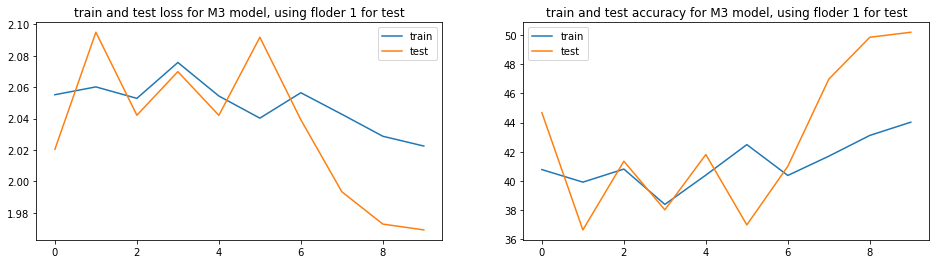

Model:M3--test_folder:2 --start_time:2019-12-12 21:57:21.213386
Model:M3--test_folder:2 -- epoch 1--start_time:2019-12-12 21:57:21.213484
Model M3--epoch:1 -- Train accuracy: 40.50%
Model M3--epoch:1 -- Test accuracy: 34.57%
Model:M3--test_folder:2-- epoch 1--end_time:2019-12-12 22:05:08.322177
Model:M3--test_folder:2 -- epoch 2--start_time:2019-12-12 22:05:08.322397
Model M3--epoch:2 -- Train accuracy: 42.24%
Model M3--epoch:2 -- Test accuracy: 37.61%
Model:M3--test_folder:2-- epoch 2--end_time:2019-12-12 22:11:55.641439
Model:M3--test_folder:2 -- epoch 3--start_time:2019-12-12 22:11:55.641491
Model M3--epoch:3 -- Train accuracy: 41.22%
Model M3--epoch:3 -- Test accuracy: 36.82%
Model:M3--test_folder:2-- epoch 3--end_time:2019-12-12 22:18:47.550078
Model:M3--test_folder:2 -- epoch 4--start_time:2019-12-12 22:18:47.550130
Model M3--epoch:4 -- Train accuracy: 42.71%
Model M3--epoch:4 -- Test accuracy: 36.71%
Model:M3--test_folder:2-- epoch 4--end_time:2019-12-12 22:25:35.389931
Model:M3

In [ ]:
run_all_models_10_times_and_plot()

In [ ]:
#plot_loss_acc([3,2,3,4],[2,3,4,5],[3,2,3,4],[3,5,4,2],3,"name_")